## Import libraries and MNIST dataset

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## Define Convolutional Autoencoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        # ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 32),
            nn.ReLU(True),
            nn.Linear(32, encoded_space_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
        
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = x.view((-1, 1, 28, 28))
        return x

## Initialize Loss function and the optimizer

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 15

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

print(encoder)
print(decoder)

Selected device: cuda
Encoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=15, bias=True)
    (5): Sigmoid()
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


## Train and evaluate model

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   


## Let's train!

	 partial train loss (single batch): 0.231786
	 partial train loss (single batch): 0.225430
	 partial train loss (single batch): 0.219496
	 partial train loss (single batch): 0.212052
	 partial train loss (single batch): 0.205392
	 partial train loss (single batch): 0.197506
	 partial train loss (single batch): 0.188787
	 partial train loss (single batch): 0.179581
	 partial train loss (single batch): 0.169253
	 partial train loss (single batch): 0.157841
	 partial train loss (single batch): 0.145680
	 partial train loss (single batch): 0.135135
	 partial train loss (single batch): 0.122130
	 partial train loss (single batch): 0.112180
	 partial train loss (single batch): 0.101851
	 partial train loss (single batch): 0.092397
	 partial train loss (single batch): 0.089104
	 partial train loss (single batch): 0.082544
	 partial train loss (single batch): 0.077764
	 partial train loss (single batch): 0.075540
	 partial train loss (single batch): 0.075106
	 partial train loss (single batch

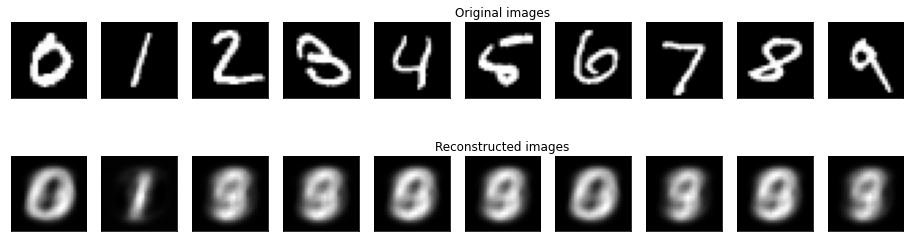

	 partial train loss (single batch): 0.059169
	 partial train loss (single batch): 0.059920
	 partial train loss (single batch): 0.060255
	 partial train loss (single batch): 0.059591
	 partial train loss (single batch): 0.059171
	 partial train loss (single batch): 0.060601
	 partial train loss (single batch): 0.060312
	 partial train loss (single batch): 0.059072
	 partial train loss (single batch): 0.059836
	 partial train loss (single batch): 0.060624
	 partial train loss (single batch): 0.059459
	 partial train loss (single batch): 0.060181
	 partial train loss (single batch): 0.058628
	 partial train loss (single batch): 0.060604
	 partial train loss (single batch): 0.059271
	 partial train loss (single batch): 0.059509
	 partial train loss (single batch): 0.061591
	 partial train loss (single batch): 0.059848
	 partial train loss (single batch): 0.059579
	 partial train loss (single batch): 0.060274
	 partial train loss (single batch): 0.059408
	 partial train loss (single batch

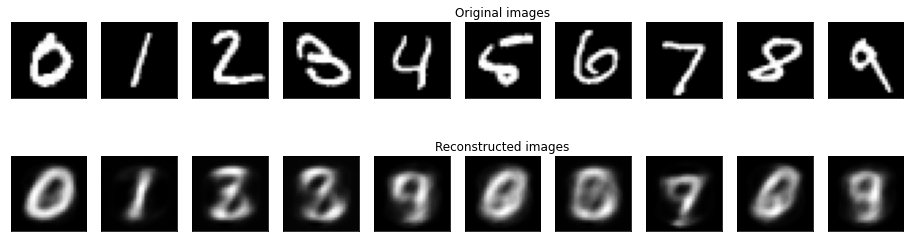

	 partial train loss (single batch): 0.048460
	 partial train loss (single batch): 0.048329
	 partial train loss (single batch): 0.048714
	 partial train loss (single batch): 0.048812
	 partial train loss (single batch): 0.047861
	 partial train loss (single batch): 0.049269
	 partial train loss (single batch): 0.048376
	 partial train loss (single batch): 0.047180
	 partial train loss (single batch): 0.048733
	 partial train loss (single batch): 0.049465
	 partial train loss (single batch): 0.047846
	 partial train loss (single batch): 0.049449
	 partial train loss (single batch): 0.046108
	 partial train loss (single batch): 0.049241
	 partial train loss (single batch): 0.047441
	 partial train loss (single batch): 0.047549
	 partial train loss (single batch): 0.049679
	 partial train loss (single batch): 0.047643
	 partial train loss (single batch): 0.048623
	 partial train loss (single batch): 0.048874
	 partial train loss (single batch): 0.048130
	 partial train loss (single batch

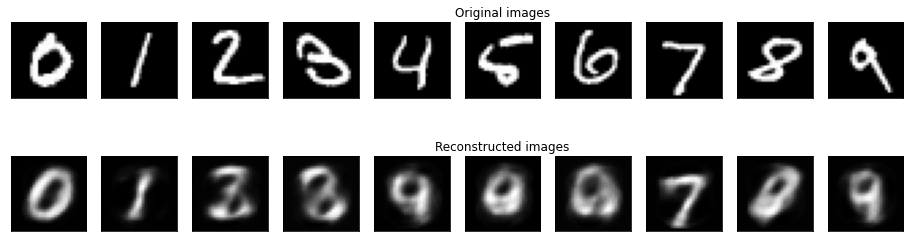

	 partial train loss (single batch): 0.040937
	 partial train loss (single batch): 0.040633
	 partial train loss (single batch): 0.040449
	 partial train loss (single batch): 0.041294
	 partial train loss (single batch): 0.040197
	 partial train loss (single batch): 0.041668
	 partial train loss (single batch): 0.040644
	 partial train loss (single batch): 0.039554
	 partial train loss (single batch): 0.040847
	 partial train loss (single batch): 0.041607
	 partial train loss (single batch): 0.040889
	 partial train loss (single batch): 0.041396
	 partial train loss (single batch): 0.038679
	 partial train loss (single batch): 0.041407
	 partial train loss (single batch): 0.040501
	 partial train loss (single batch): 0.040618
	 partial train loss (single batch): 0.041928
	 partial train loss (single batch): 0.041012
	 partial train loss (single batch): 0.041381
	 partial train loss (single batch): 0.041221
	 partial train loss (single batch): 0.041119
	 partial train loss (single batch

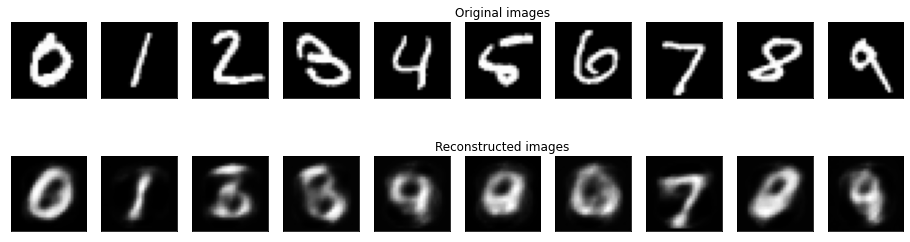

	 partial train loss (single batch): 0.037199
	 partial train loss (single batch): 0.036642
	 partial train loss (single batch): 0.036425
	 partial train loss (single batch): 0.037089
	 partial train loss (single batch): 0.036321
	 partial train loss (single batch): 0.037292
	 partial train loss (single batch): 0.036529
	 partial train loss (single batch): 0.035748
	 partial train loss (single batch): 0.037127
	 partial train loss (single batch): 0.037240
	 partial train loss (single batch): 0.037256
	 partial train loss (single batch): 0.037436
	 partial train loss (single batch): 0.034920
	 partial train loss (single batch): 0.037135
	 partial train loss (single batch): 0.036747
	 partial train loss (single batch): 0.036770
	 partial train loss (single batch): 0.038045
	 partial train loss (single batch): 0.037175
	 partial train loss (single batch): 0.037774
	 partial train loss (single batch): 0.037320
	 partial train loss (single batch): 0.037203
	 partial train loss (single batch

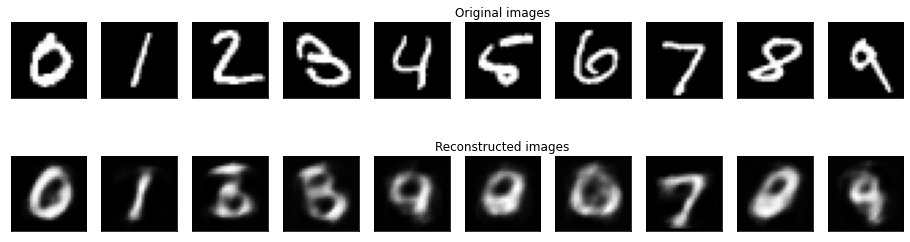

	 partial train loss (single batch): 0.034960
	 partial train loss (single batch): 0.034562
	 partial train loss (single batch): 0.033918
	 partial train loss (single batch): 0.034955
	 partial train loss (single batch): 0.034044
	 partial train loss (single batch): 0.035031
	 partial train loss (single batch): 0.034102
	 partial train loss (single batch): 0.033409
	 partial train loss (single batch): 0.034704
	 partial train loss (single batch): 0.034944
	 partial train loss (single batch): 0.034887
	 partial train loss (single batch): 0.034489
	 partial train loss (single batch): 0.032613
	 partial train loss (single batch): 0.034503
	 partial train loss (single batch): 0.034420
	 partial train loss (single batch): 0.034358
	 partial train loss (single batch): 0.035711
	 partial train loss (single batch): 0.034699
	 partial train loss (single batch): 0.035254
	 partial train loss (single batch): 0.034942
	 partial train loss (single batch): 0.034739
	 partial train loss (single batch

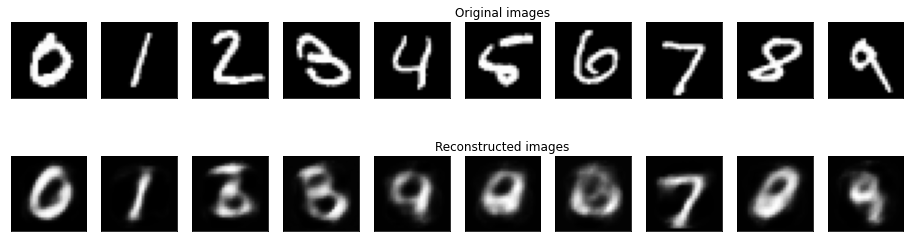

	 partial train loss (single batch): 0.032898
	 partial train loss (single batch): 0.032624
	 partial train loss (single batch): 0.032090
	 partial train loss (single batch): 0.032842
	 partial train loss (single batch): 0.032136
	 partial train loss (single batch): 0.033061
	 partial train loss (single batch): 0.032065
	 partial train loss (single batch): 0.031430
	 partial train loss (single batch): 0.032840
	 partial train loss (single batch): 0.033023
	 partial train loss (single batch): 0.032952
	 partial train loss (single batch): 0.032251
	 partial train loss (single batch): 0.030793
	 partial train loss (single batch): 0.032516
	 partial train loss (single batch): 0.032836
	 partial train loss (single batch): 0.032477
	 partial train loss (single batch): 0.034038
	 partial train loss (single batch): 0.032725
	 partial train loss (single batch): 0.033311
	 partial train loss (single batch): 0.033106
	 partial train loss (single batch): 0.032949
	 partial train loss (single batch

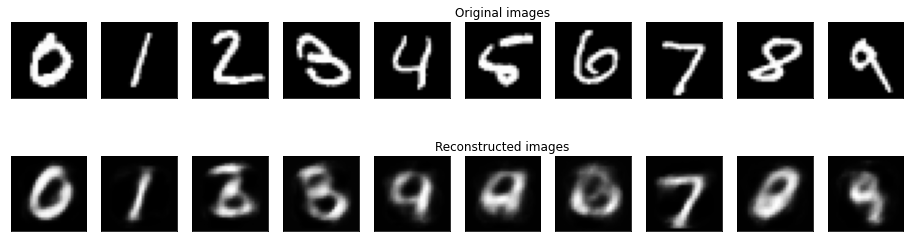

	 partial train loss (single batch): 0.031722
	 partial train loss (single batch): 0.031359
	 partial train loss (single batch): 0.030907
	 partial train loss (single batch): 0.031577
	 partial train loss (single batch): 0.030872
	 partial train loss (single batch): 0.031778
	 partial train loss (single batch): 0.030841
	 partial train loss (single batch): 0.030217
	 partial train loss (single batch): 0.031721
	 partial train loss (single batch): 0.031765
	 partial train loss (single batch): 0.031713
	 partial train loss (single batch): 0.031014
	 partial train loss (single batch): 0.029650
	 partial train loss (single batch): 0.031232
	 partial train loss (single batch): 0.031695
	 partial train loss (single batch): 0.031258
	 partial train loss (single batch): 0.032855
	 partial train loss (single batch): 0.031493
	 partial train loss (single batch): 0.032162
	 partial train loss (single batch): 0.031833
	 partial train loss (single batch): 0.031793
	 partial train loss (single batch

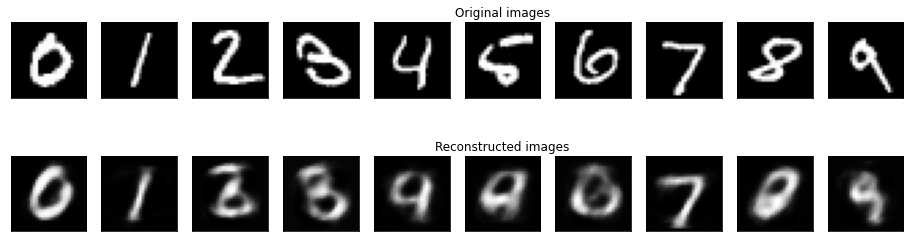

	 partial train loss (single batch): 0.030588
	 partial train loss (single batch): 0.030127
	 partial train loss (single batch): 0.029841
	 partial train loss (single batch): 0.030362
	 partial train loss (single batch): 0.029747
	 partial train loss (single batch): 0.030646
	 partial train loss (single batch): 0.029798
	 partial train loss (single batch): 0.029105
	 partial train loss (single batch): 0.030752
	 partial train loss (single batch): 0.030608
	 partial train loss (single batch): 0.030615
	 partial train loss (single batch): 0.029946
	 partial train loss (single batch): 0.028581
	 partial train loss (single batch): 0.030149
	 partial train loss (single batch): 0.030590
	 partial train loss (single batch): 0.030159
	 partial train loss (single batch): 0.031691
	 partial train loss (single batch): 0.030340
	 partial train loss (single batch): 0.031134
	 partial train loss (single batch): 0.030705
	 partial train loss (single batch): 0.030698
	 partial train loss (single batch

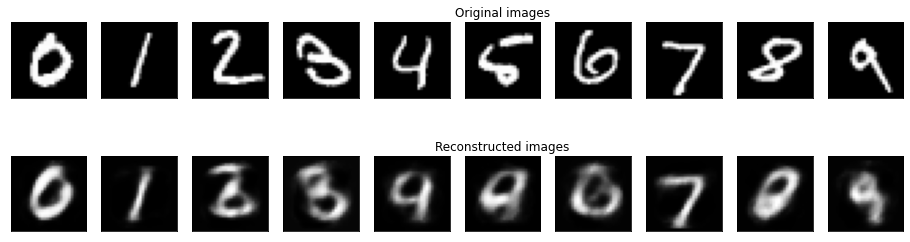

	 partial train loss (single batch): 0.029548
	 partial train loss (single batch): 0.029043
	 partial train loss (single batch): 0.028840
	 partial train loss (single batch): 0.029225
	 partial train loss (single batch): 0.028747
	 partial train loss (single batch): 0.029571
	 partial train loss (single batch): 0.028806
	 partial train loss (single batch): 0.028150
	 partial train loss (single batch): 0.029728
	 partial train loss (single batch): 0.029567
	 partial train loss (single batch): 0.029631
	 partial train loss (single batch): 0.028971
	 partial train loss (single batch): 0.027536
	 partial train loss (single batch): 0.029122
	 partial train loss (single batch): 0.029533
	 partial train loss (single batch): 0.029170
	 partial train loss (single batch): 0.030636
	 partial train loss (single batch): 0.029306
	 partial train loss (single batch): 0.030168
	 partial train loss (single batch): 0.029737
	 partial train loss (single batch): 0.029795
	 partial train loss (single batch

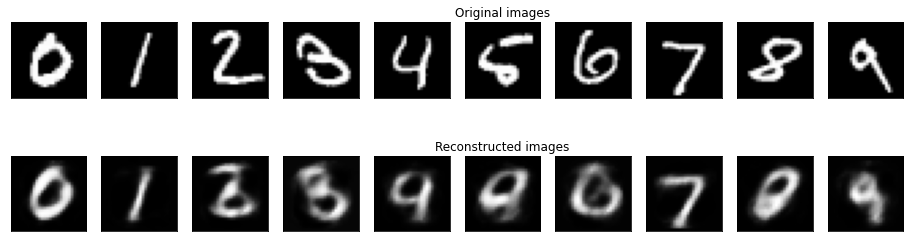

	 partial train loss (single batch): 0.028748
	 partial train loss (single batch): 0.028129
	 partial train loss (single batch): 0.028022
	 partial train loss (single batch): 0.028336
	 partial train loss (single batch): 0.027974
	 partial train loss (single batch): 0.028707
	 partial train loss (single batch): 0.027968
	 partial train loss (single batch): 0.027331
	 partial train loss (single batch): 0.028840
	 partial train loss (single batch): 0.028742
	 partial train loss (single batch): 0.028852
	 partial train loss (single batch): 0.028215
	 partial train loss (single batch): 0.026672
	 partial train loss (single batch): 0.028278
	 partial train loss (single batch): 0.028745
	 partial train loss (single batch): 0.028464
	 partial train loss (single batch): 0.029820
	 partial train loss (single batch): 0.028567
	 partial train loss (single batch): 0.029354
	 partial train loss (single batch): 0.029024
	 partial train loss (single batch): 0.029017
	 partial train loss (single batch

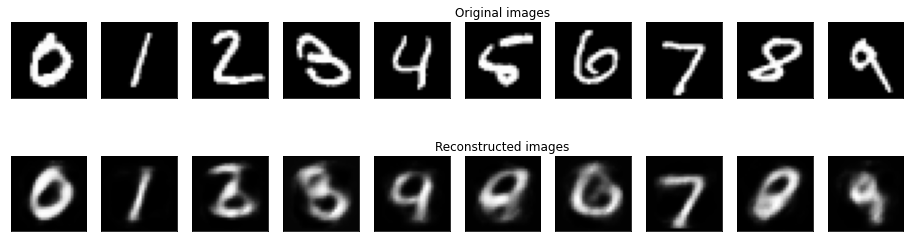

	 partial train loss (single batch): 0.028071
	 partial train loss (single batch): 0.027470
	 partial train loss (single batch): 0.027349
	 partial train loss (single batch): 0.027698
	 partial train loss (single batch): 0.027386
	 partial train loss (single batch): 0.028037
	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.026660
	 partial train loss (single batch): 0.028270
	 partial train loss (single batch): 0.028086
	 partial train loss (single batch): 0.028267
	 partial train loss (single batch): 0.027610
	 partial train loss (single batch): 0.025992
	 partial train loss (single batch): 0.027731
	 partial train loss (single batch): 0.028061
	 partial train loss (single batch): 0.028022
	 partial train loss (single batch): 0.029178
	 partial train loss (single batch): 0.027724
	 partial train loss (single batch): 0.028796
	 partial train loss (single batch): 0.028202
	 partial train loss (single batch): 0.028300
	 partial train loss (single batch

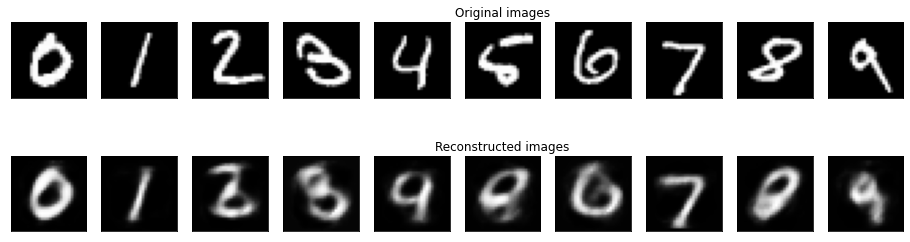

	 partial train loss (single batch): 0.027472
	 partial train loss (single batch): 0.026828
	 partial train loss (single batch): 0.026711
	 partial train loss (single batch): 0.027126
	 partial train loss (single batch): 0.026765
	 partial train loss (single batch): 0.027447
	 partial train loss (single batch): 0.026817
	 partial train loss (single batch): 0.026039
	 partial train loss (single batch): 0.027739
	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.027735
	 partial train loss (single batch): 0.026941
	 partial train loss (single batch): 0.025444
	 partial train loss (single batch): 0.027072
	 partial train loss (single batch): 0.027483
	 partial train loss (single batch): 0.027526
	 partial train loss (single batch): 0.028459
	 partial train loss (single batch): 0.027083
	 partial train loss (single batch): 0.028058
	 partial train loss (single batch): 0.027541
	 partial train loss (single batch): 0.027687
	 partial train loss (single batch

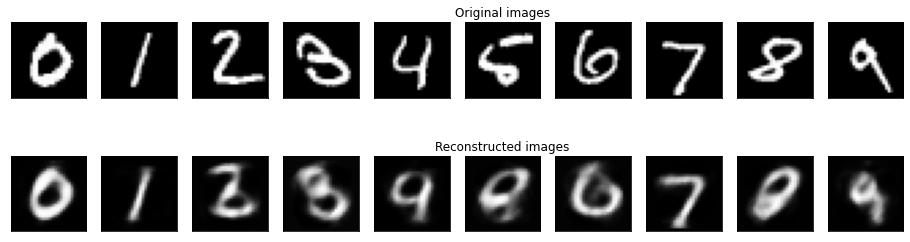

	 partial train loss (single batch): 0.026966
	 partial train loss (single batch): 0.026237
	 partial train loss (single batch): 0.026169
	 partial train loss (single batch): 0.026603
	 partial train loss (single batch): 0.026216
	 partial train loss (single batch): 0.026922
	 partial train loss (single batch): 0.026268
	 partial train loss (single batch): 0.025506
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch): 0.026835
	 partial train loss (single batch): 0.027219
	 partial train loss (single batch): 0.026367
	 partial train loss (single batch): 0.024917
	 partial train loss (single batch): 0.026501
	 partial train loss (single batch): 0.026985
	 partial train loss (single batch): 0.027001
	 partial train loss (single batch): 0.027898
	 partial train loss (single batch): 0.026473
	 partial train loss (single batch): 0.027445
	 partial train loss (single batch): 0.026967
	 partial train loss (single batch): 0.027161
	 partial train loss (single batch

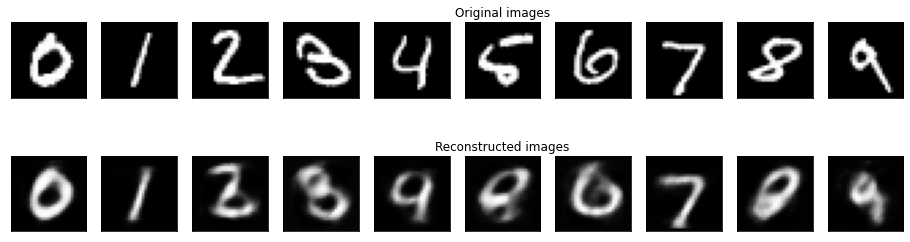

	 partial train loss (single batch): 0.026496
	 partial train loss (single batch): 0.025684
	 partial train loss (single batch): 0.025693
	 partial train loss (single batch): 0.026118
	 partial train loss (single batch): 0.025691
	 partial train loss (single batch): 0.026407
	 partial train loss (single batch): 0.025761
	 partial train loss (single batch): 0.025017
	 partial train loss (single batch): 0.026727
	 partial train loss (single batch): 0.026301
	 partial train loss (single batch): 0.026746
	 partial train loss (single batch): 0.025854
	 partial train loss (single batch): 0.024418
	 partial train loss (single batch): 0.025980
	 partial train loss (single batch): 0.026515
	 partial train loss (single batch): 0.026503
	 partial train loss (single batch): 0.027408
	 partial train loss (single batch): 0.025921
	 partial train loss (single batch): 0.026888
	 partial train loss (single batch): 0.026425
	 partial train loss (single batch): 0.026694
	 partial train loss (single batch

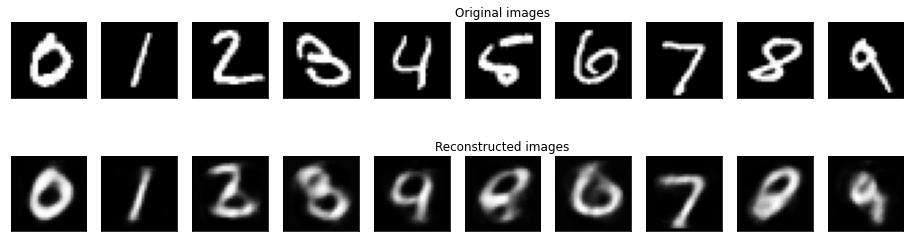

	 partial train loss (single batch): 0.026040
	 partial train loss (single batch): 0.025189
	 partial train loss (single batch): 0.025250
	 partial train loss (single batch): 0.025691
	 partial train loss (single batch): 0.025197
	 partial train loss (single batch): 0.025929
	 partial train loss (single batch): 0.025287
	 partial train loss (single batch): 0.024562
	 partial train loss (single batch): 0.026273
	 partial train loss (single batch): 0.025791
	 partial train loss (single batch): 0.026288
	 partial train loss (single batch): 0.025354
	 partial train loss (single batch): 0.023955
	 partial train loss (single batch): 0.025485
	 partial train loss (single batch): 0.026057
	 partial train loss (single batch): 0.026057
	 partial train loss (single batch): 0.026954
	 partial train loss (single batch): 0.025434
	 partial train loss (single batch): 0.026382
	 partial train loss (single batch): 0.025910
	 partial train loss (single batch): 0.026236
	 partial train loss (single batch

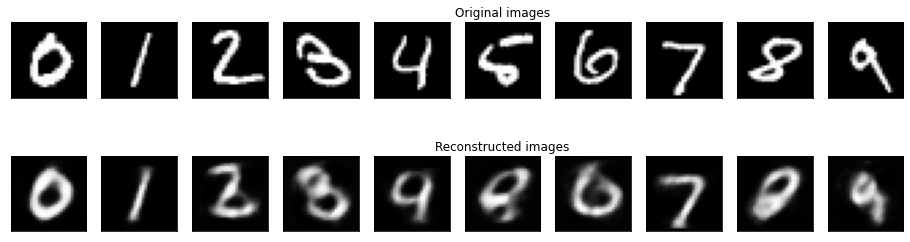

	 partial train loss (single batch): 0.025593
	 partial train loss (single batch): 0.024691
	 partial train loss (single batch): 0.024821
	 partial train loss (single batch): 0.025273
	 partial train loss (single batch): 0.024723
	 partial train loss (single batch): 0.025477
	 partial train loss (single batch): 0.024798
	 partial train loss (single batch): 0.024155
	 partial train loss (single batch): 0.025786
	 partial train loss (single batch): 0.025278
	 partial train loss (single batch): 0.025813
	 partial train loss (single batch): 0.024832
	 partial train loss (single batch): 0.023497
	 partial train loss (single batch): 0.024923
	 partial train loss (single batch): 0.025587
	 partial train loss (single batch): 0.025621
	 partial train loss (single batch): 0.026489
	 partial train loss (single batch): 0.024933
	 partial train loss (single batch): 0.025897
	 partial train loss (single batch): 0.025388
	 partial train loss (single batch): 0.025780
	 partial train loss (single batch

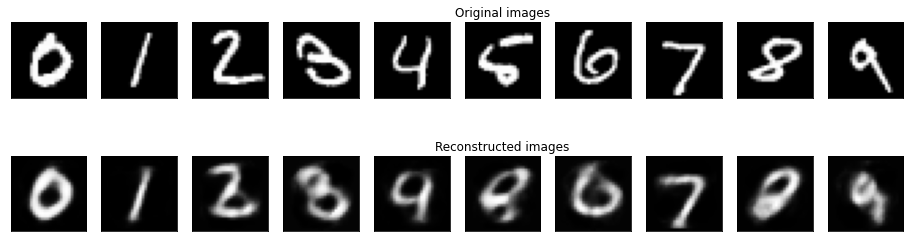

	 partial train loss (single batch): 0.025096
	 partial train loss (single batch): 0.024189
	 partial train loss (single batch): 0.024331
	 partial train loss (single batch): 0.024819
	 partial train loss (single batch): 0.024255
	 partial train loss (single batch): 0.024941
	 partial train loss (single batch): 0.024311
	 partial train loss (single batch): 0.023628
	 partial train loss (single batch): 0.025256
	 partial train loss (single batch): 0.024769
	 partial train loss (single batch): 0.025276
	 partial train loss (single batch): 0.024337
	 partial train loss (single batch): 0.022952
	 partial train loss (single batch): 0.024372
	 partial train loss (single batch): 0.025025
	 partial train loss (single batch): 0.025184
	 partial train loss (single batch): 0.025988
	 partial train loss (single batch): 0.024420
	 partial train loss (single batch): 0.025444
	 partial train loss (single batch): 0.024877
	 partial train loss (single batch): 0.025343
	 partial train loss (single batch

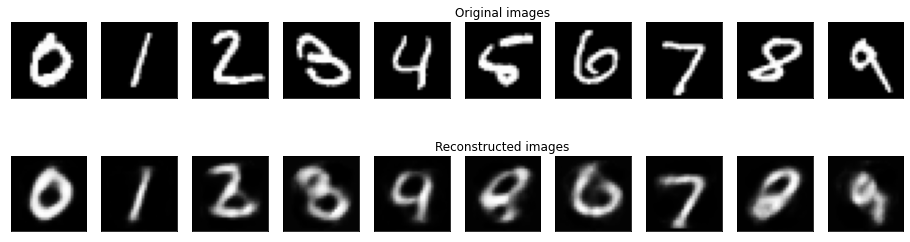

	 partial train loss (single batch): 0.024632
	 partial train loss (single batch): 0.023666
	 partial train loss (single batch): 0.023873
	 partial train loss (single batch): 0.024393
	 partial train loss (single batch): 0.023850
	 partial train loss (single batch): 0.024469
	 partial train loss (single batch): 0.023859
	 partial train loss (single batch): 0.023170
	 partial train loss (single batch): 0.024751
	 partial train loss (single batch): 0.024360
	 partial train loss (single batch): 0.024795
	 partial train loss (single batch): 0.023935
	 partial train loss (single batch): 0.022472
	 partial train loss (single batch): 0.023894
	 partial train loss (single batch): 0.024495
	 partial train loss (single batch): 0.024743
	 partial train loss (single batch): 0.025543
	 partial train loss (single batch): 0.023947
	 partial train loss (single batch): 0.025057
	 partial train loss (single batch): 0.024484
	 partial train loss (single batch): 0.024968
	 partial train loss (single batch

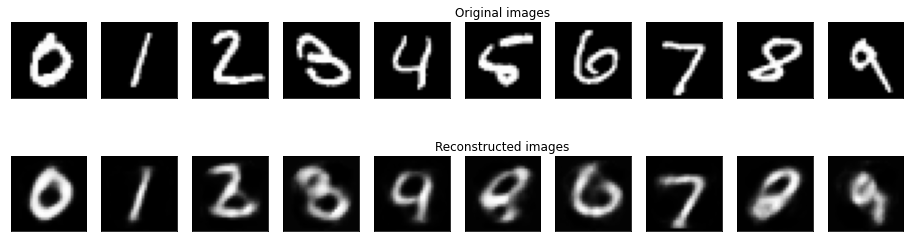

	 partial train loss (single batch): 0.024250
	 partial train loss (single batch): 0.023239
	 partial train loss (single batch): 0.023479
	 partial train loss (single batch): 0.024052
	 partial train loss (single batch): 0.023526
	 partial train loss (single batch): 0.024092
	 partial train loss (single batch): 0.023457
	 partial train loss (single batch): 0.022766
	 partial train loss (single batch): 0.024334
	 partial train loss (single batch): 0.024036
	 partial train loss (single batch): 0.024393
	 partial train loss (single batch): 0.023586
	 partial train loss (single batch): 0.022070
	 partial train loss (single batch): 0.023506
	 partial train loss (single batch): 0.024065
	 partial train loss (single batch): 0.024363
	 partial train loss (single batch): 0.025168
	 partial train loss (single batch): 0.023543
	 partial train loss (single batch): 0.024688
	 partial train loss (single batch): 0.024134
	 partial train loss (single batch): 0.024620
	 partial train loss (single batch

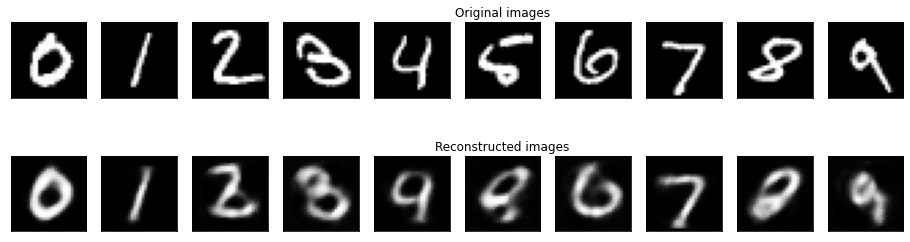

	 partial train loss (single batch): 0.023893
	 partial train loss (single batch): 0.022885
	 partial train loss (single batch): 0.023138
	 partial train loss (single batch): 0.023737
	 partial train loss (single batch): 0.023234
	 partial train loss (single batch): 0.023765
	 partial train loss (single batch): 0.023095
	 partial train loss (single batch): 0.022367
	 partial train loss (single batch): 0.023995
	 partial train loss (single batch): 0.023706
	 partial train loss (single batch): 0.024061
	 partial train loss (single batch): 0.023244
	 partial train loss (single batch): 0.021718
	 partial train loss (single batch): 0.023148
	 partial train loss (single batch): 0.023709
	 partial train loss (single batch): 0.024028
	 partial train loss (single batch): 0.024801
	 partial train loss (single batch): 0.023188
	 partial train loss (single batch): 0.024355
	 partial train loss (single batch): 0.023781
	 partial train loss (single batch): 0.024277
	 partial train loss (single batch

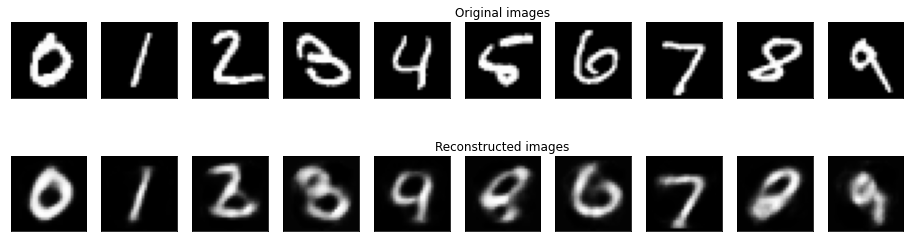

	 partial train loss (single batch): 0.023577
	 partial train loss (single batch): 0.022562
	 partial train loss (single batch): 0.022810
	 partial train loss (single batch): 0.023468
	 partial train loss (single batch): 0.022934
	 partial train loss (single batch): 0.023512
	 partial train loss (single batch): 0.022776
	 partial train loss (single batch): 0.022035
	 partial train loss (single batch): 0.023696
	 partial train loss (single batch): 0.023422
	 partial train loss (single batch): 0.023825
	 partial train loss (single batch): 0.022954
	 partial train loss (single batch): 0.021435
	 partial train loss (single batch): 0.022869
	 partial train loss (single batch): 0.023417
	 partial train loss (single batch): 0.023739
	 partial train loss (single batch): 0.024529
	 partial train loss (single batch): 0.022912
	 partial train loss (single batch): 0.024048
	 partial train loss (single batch): 0.023496
	 partial train loss (single batch): 0.023994
	 partial train loss (single batch

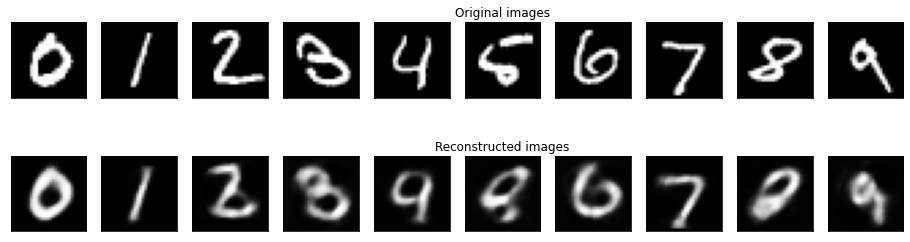

	 partial train loss (single batch): 0.023230
	 partial train loss (single batch): 0.022223
	 partial train loss (single batch): 0.022462
	 partial train loss (single batch): 0.023161
	 partial train loss (single batch): 0.022623
	 partial train loss (single batch): 0.023243
	 partial train loss (single batch): 0.022447
	 partial train loss (single batch): 0.021675
	 partial train loss (single batch): 0.023417
	 partial train loss (single batch): 0.023137
	 partial train loss (single batch): 0.023577
	 partial train loss (single batch): 0.022647
	 partial train loss (single batch): 0.021153
	 partial train loss (single batch): 0.022574
	 partial train loss (single batch): 0.023127
	 partial train loss (single batch): 0.023460
	 partial train loss (single batch): 0.024231
	 partial train loss (single batch): 0.022657
	 partial train loss (single batch): 0.023735
	 partial train loss (single batch): 0.023199
	 partial train loss (single batch): 0.023685
	 partial train loss (single batch

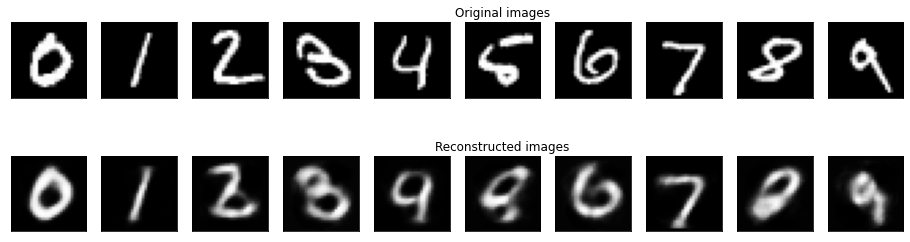

	 partial train loss (single batch): 0.022885
	 partial train loss (single batch): 0.021858
	 partial train loss (single batch): 0.022101
	 partial train loss (single batch): 0.022790
	 partial train loss (single batch): 0.022308
	 partial train loss (single batch): 0.022938
	 partial train loss (single batch): 0.022077
	 partial train loss (single batch): 0.021285
	 partial train loss (single batch): 0.023053
	 partial train loss (single batch): 0.022833
	 partial train loss (single batch): 0.023249
	 partial train loss (single batch): 0.022317
	 partial train loss (single batch): 0.020812
	 partial train loss (single batch): 0.022244
	 partial train loss (single batch): 0.022747
	 partial train loss (single batch): 0.023093
	 partial train loss (single batch): 0.023902
	 partial train loss (single batch): 0.022355
	 partial train loss (single batch): 0.023371
	 partial train loss (single batch): 0.022836
	 partial train loss (single batch): 0.023294
	 partial train loss (single batch

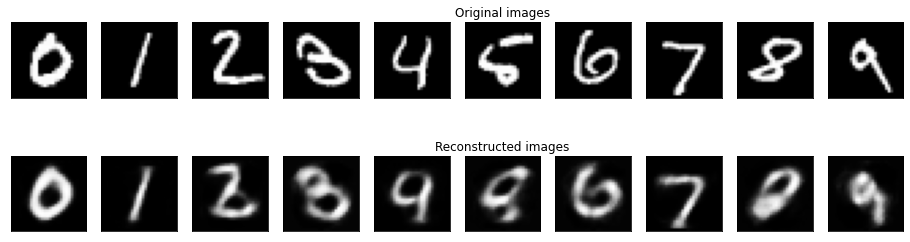

	 partial train loss (single batch): 0.022494
	 partial train loss (single batch): 0.021459
	 partial train loss (single batch): 0.021691
	 partial train loss (single batch): 0.022398
	 partial train loss (single batch): 0.021955
	 partial train loss (single batch): 0.022569
	 partial train loss (single batch): 0.021695
	 partial train loss (single batch): 0.020873
	 partial train loss (single batch): 0.022673
	 partial train loss (single batch): 0.022491
	 partial train loss (single batch): 0.022943
	 partial train loss (single batch): 0.021957
	 partial train loss (single batch): 0.020472
	 partial train loss (single batch): 0.021877
	 partial train loss (single batch): 0.022367
	 partial train loss (single batch): 0.022738
	 partial train loss (single batch): 0.023563
	 partial train loss (single batch): 0.022035
	 partial train loss (single batch): 0.023007
	 partial train loss (single batch): 0.022476
	 partial train loss (single batch): 0.022925
	 partial train loss (single batch

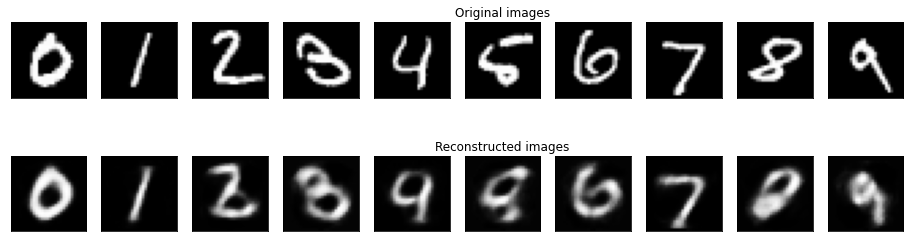

	 partial train loss (single batch): 0.022158
	 partial train loss (single batch): 0.021096
	 partial train loss (single batch): 0.021342
	 partial train loss (single batch): 0.022050
	 partial train loss (single batch): 0.021639
	 partial train loss (single batch): 0.022272
	 partial train loss (single batch): 0.021381
	 partial train loss (single batch): 0.020569
	 partial train loss (single batch): 0.022381
	 partial train loss (single batch): 0.022184
	 partial train loss (single batch): 0.022667
	 partial train loss (single batch): 0.021634
	 partial train loss (single batch): 0.020150
	 partial train loss (single batch): 0.021540
	 partial train loss (single batch): 0.022001
	 partial train loss (single batch): 0.022423
	 partial train loss (single batch): 0.023256
	 partial train loss (single batch): 0.021739
	 partial train loss (single batch): 0.022651
	 partial train loss (single batch): 0.022114
	 partial train loss (single batch): 0.022557
	 partial train loss (single batch

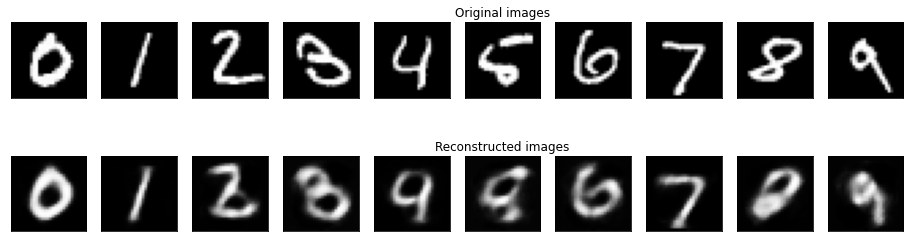

	 partial train loss (single batch): 0.021816
	 partial train loss (single batch): 0.020789
	 partial train loss (single batch): 0.021043
	 partial train loss (single batch): 0.021710
	 partial train loss (single batch): 0.021366
	 partial train loss (single batch): 0.021977
	 partial train loss (single batch): 0.021108
	 partial train loss (single batch): 0.020294
	 partial train loss (single batch): 0.022092
	 partial train loss (single batch): 0.021881
	 partial train loss (single batch): 0.022413
	 partial train loss (single batch): 0.021335
	 partial train loss (single batch): 0.019869
	 partial train loss (single batch): 0.021237
	 partial train loss (single batch): 0.021699
	 partial train loss (single batch): 0.022134
	 partial train loss (single batch): 0.022937
	 partial train loss (single batch): 0.021500
	 partial train loss (single batch): 0.022291
	 partial train loss (single batch): 0.021802
	 partial train loss (single batch): 0.022281
	 partial train loss (single batch

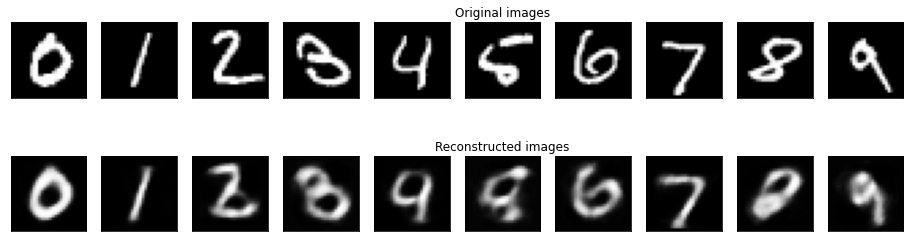

	 partial train loss (single batch): 0.021488
	 partial train loss (single batch): 0.020485
	 partial train loss (single batch): 0.020793
	 partial train loss (single batch): 0.021387
	 partial train loss (single batch): 0.021122
	 partial train loss (single batch): 0.021669
	 partial train loss (single batch): 0.020859
	 partial train loss (single batch): 0.020044
	 partial train loss (single batch): 0.021795
	 partial train loss (single batch): 0.021598
	 partial train loss (single batch): 0.022128
	 partial train loss (single batch): 0.021053
	 partial train loss (single batch): 0.019638
	 partial train loss (single batch): 0.020920
	 partial train loss (single batch): 0.021416
	 partial train loss (single batch): 0.021834
	 partial train loss (single batch): 0.022670
	 partial train loss (single batch): 0.021263
	 partial train loss (single batch): 0.021994
	 partial train loss (single batch): 0.021528
	 partial train loss (single batch): 0.021989
	 partial train loss (single batch

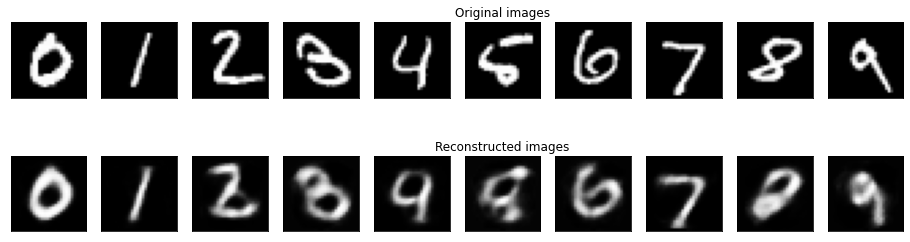

	 partial train loss (single batch): 0.021187
	 partial train loss (single batch): 0.020244
	 partial train loss (single batch): 0.020567
	 partial train loss (single batch): 0.021127
	 partial train loss (single batch): 0.020910
	 partial train loss (single batch): 0.021407
	 partial train loss (single batch): 0.020639
	 partial train loss (single batch): 0.019836
	 partial train loss (single batch): 0.021551
	 partial train loss (single batch): 0.021342
	 partial train loss (single batch): 0.021907
	 partial train loss (single batch): 0.020818
	 partial train loss (single batch): 0.019441
	 partial train loss (single batch): 0.020658
	 partial train loss (single batch): 0.021170
	 partial train loss (single batch): 0.021624
	 partial train loss (single batch): 0.022424
	 partial train loss (single batch): 0.021052
	 partial train loss (single batch): 0.021746
	 partial train loss (single batch): 0.021277
	 partial train loss (single batch): 0.021739
	 partial train loss (single batch

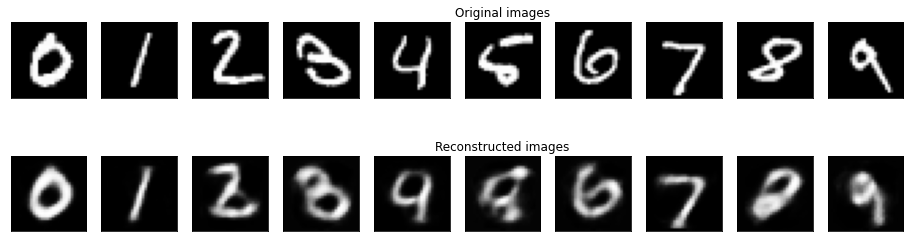

	 partial train loss (single batch): 0.020913
	 partial train loss (single batch): 0.019993
	 partial train loss (single batch): 0.020340
	 partial train loss (single batch): 0.020868
	 partial train loss (single batch): 0.020713
	 partial train loss (single batch): 0.021177
	 partial train loss (single batch): 0.020421
	 partial train loss (single batch): 0.019647
	 partial train loss (single batch): 0.021337
	 partial train loss (single batch): 0.021091
	 partial train loss (single batch): 0.021710
	 partial train loss (single batch): 0.020620
	 partial train loss (single batch): 0.019228
	 partial train loss (single batch): 0.020466
	 partial train loss (single batch): 0.020889
	 partial train loss (single batch): 0.021444
	 partial train loss (single batch): 0.022169
	 partial train loss (single batch): 0.020873
	 partial train loss (single batch): 0.021557
	 partial train loss (single batch): 0.021034
	 partial train loss (single batch): 0.021535
	 partial train loss (single batch

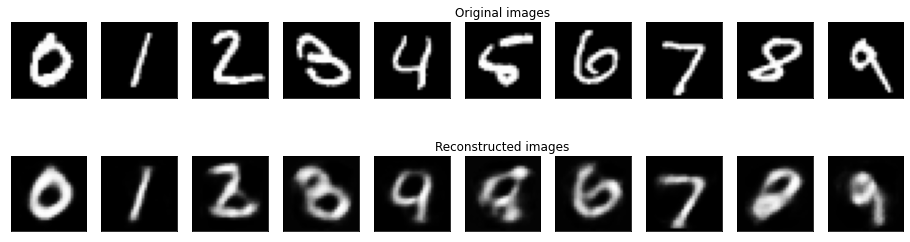

In [ ]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)


## 

## Final evaluations

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02024572156369686

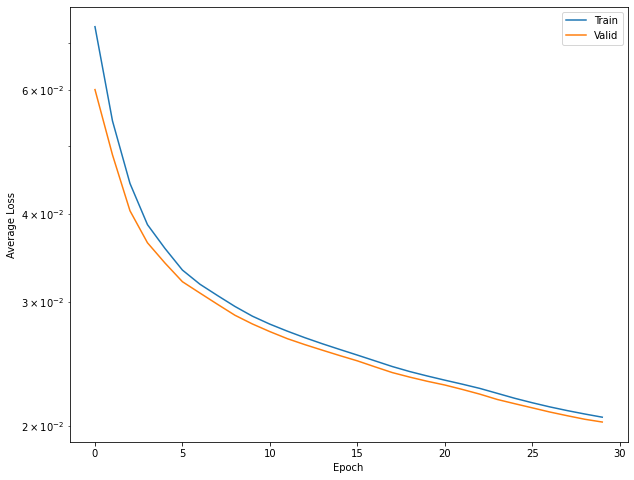

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()


In [ ]:
torch.save(encoder.state_dict(), "encoder.pt")
torch.save(decoder.state_dict(), "decoder.pt")